In [2]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import (
    UserFloatingEsc,
)

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

from abm1559.txs import (
    TxFloatingEsc,
)

import pandas as pd
import numpy as np
import seaborn as sns

In [50]:
alice = UserFloatingEsc(0)
alice.value = 10
alice.cost_per_unit = 0.8

bob = UserFloatingEsc(0)
bob.value = 7
bob.cost_per_unit = 1.2

In [51]:
tx_params_alice = alice.decide_parameters({ "basefee": 1, "current_block": 0 })
tx_alice = TxFloatingEsc(
    sender = alice.pub_key,
    params = tx_params_alice
)
print(tx_alice)

Floating Escalator Transaction 44607edc3f58b788: start block 0, max block 5, start premium 0.8333333333333334, max premium 5.0, max fee 6.0


In [52]:
tx_params_bob = bob.decide_parameters({ "basefee": 1, "current_block": 0 })
tx_bob = TxFloatingEsc(
    sender = bob.pub_key,
    params = tx_params_bob
)
print(tx_bob)

Floating Escalator Transaction 5fc9d860b31f6663: start block 0, max block 5, start premium 0.0, max premium 0.0, max fee 1.0


In [53]:
a = range(tx_params_alice["max_block"] + 1)
b = range(tx_params_bob["max_block"] + 1)

bfs = [i for i in a]
gps_a = [tx_alice.gas_price({ "basefee": bfs[i], "current_block": i }) for i in a]
gps_b = [tx_bob.gas_price({ "basefee": bfs[i], "current_block": i }) for i in b]
vft_a = [alice.value - i * alice.cost_per_unit for i in a]
vft_b = [bob.value - i * bob.cost_per_unit for i in b]

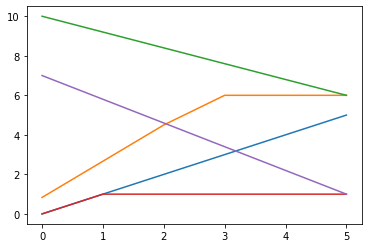

In [54]:
import matplotlib.pyplot as plt

plt.plot(a, bfs, a, gps_a, a, vft_a, b, gps_b, b, vft_b)

In [2]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])
        txpool.remove_invalid_txs(params)

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)
        
        # The block is added to the chain
        chain.add_block(block)

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [3]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

strategic_share = 0.5
shares_scenario = [{
    UserFloatingEsc: 1,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

In [4]:
df

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,2557,2264,952,3.172149,2.172149,1177
1,1,1.124900,2520,2205,952,3.502666,2.377766,2278
2,2,1.265400,2472,2140,952,3.995998,2.730598,3275
3,3,1.423448,2397,2086,952,4.587841,3.164393,4164
4,4,1.601237,2534,2225,952,5.232446,3.631208,5136
...,...,...,...,...,...,...,...,...
95,95,13.714318,2640,2323,497,14.097663,0.383345,0
96,96,13.789233,2418,2115,474,14.133338,0.344105,0
97,97,13.781304,2579,2252,503,14.140651,0.359347,0
98,98,13.878290,2441,2149,428,14.228865,0.350576,0


<AxesSubplot:xlabel='block'>

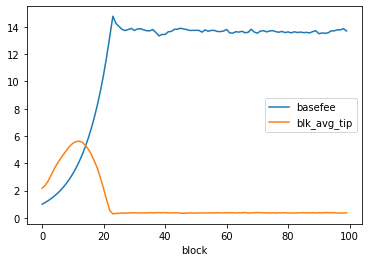

In [5]:
df.plot("block", ["basefee", "blk_avg_tip"])

<AxesSubplot:xlabel='block'>

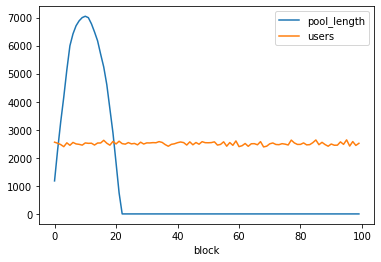

In [6]:
df.plot("block", ["pool_length", "users"])

In [7]:
from math import isnan

# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })
user_pool_df = user_pool_df.assign(slope = user_pool_df.apply(
    lambda row: (row["value"] - 5 * row["cost_per_unit"] - 2) / 5,
    axis = 1,
))

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = user_pool_df.set_index("sender").join(
    chain_df.set_index("sender"), how="outer", rsuffix = "-tx"
)
user_txs_df = user_txs_df.assign(
    included = pd.notna(user_txs_df["block_height"])
)
user_txs_df = user_txs_df.assign(
    payoff = user_txs_df.apply(
        lambda row: np.nan if pd.isna(row.block_height) else row.user.payoff({
            "current_block": row.block_height,
            "gas_price": row["tx"].gas_price({
                "basefee": row.basefee * (10 ** 9),
                "current_block": row.block_height,
            })
        }) / (10 ** 9), # put payoff is in Gwei
        axis = 1
    )
)

In [8]:
user_txs_df

,user,value,wakeup_block,user_type,cost_per_unit,slope,block_height,tx_index,basefee,tx,start_block,gas_used,tx_hash,start_premium,max_fee,tip,slope-tx,included,payoff
sender,,,,,,,,,,,,,,,,,,,
000007defda7fd17,Floating escalator affine user with value 1052...,10.524040,8,user_floatingesc,0.692583,1.012225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
000045cb26d0fbf1,Floating escalator affine user with value 1188...,11.888416,59,user_floatingesc,0.815147,1.162537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
00004a52fe27149f,Floating escalator affine user with value 4543...,4.543054,6,user_floatingesc,0.163489,0.345121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
00004cf7704d106f,Floating escalator affine user with value 4190...,4.190988,5,user_floatingesc,0.488131,-0.049933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
0000692a476ce77e,Floating escalator affine user with value 1823...,18.237589,51,user_floatingesc,0.371844,2.875674,51.0,141.0,13.745814,Floating Escalator Transaction 9aa074026682251...,51.0,21000.0,9aa0740266822519,0.438759,16.378368,0.438759,0.351007,True,4.053015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffee620f69a1bbc,Floating escalator affine user with value 3188...,3.188130,3,user_floatingesc,0.190514,0.047112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
ffff1463261cb97b,Floating escalator affine user with value 7560...,7.560921,8,user_floatingesc,0.518328,0.593856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
ffffa12d6d6f3e5e,Floating escalator affine user with value 1935...,19.350589,0,user_floatingesc,0.778733,2.691385,0.0,272.0,1.000000,Floating Escalator Transaction 844eb68b692dd97...,0.0,21000.0,844eb68b692dd97b,2.409487,15.456924,2.409487,1.927590,True,15.941102


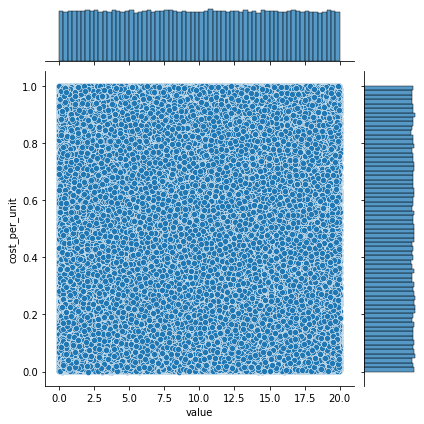

In [9]:
g = sns.JointGrid(data=user_txs_df, x="value", y="cost_per_unit")
g.plot(sns.scatterplot, sns.histplot)

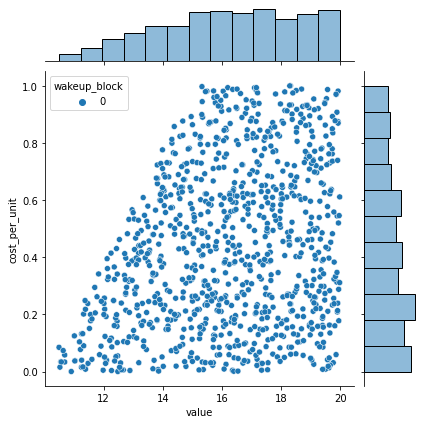

In [10]:
g = sns.JointGrid(data=user_txs_df[user_txs_df.block_height == 0], x="value", y="cost_per_unit", hue="wakeup_block")
g.plot(sns.scatterplot, sns.histplot)

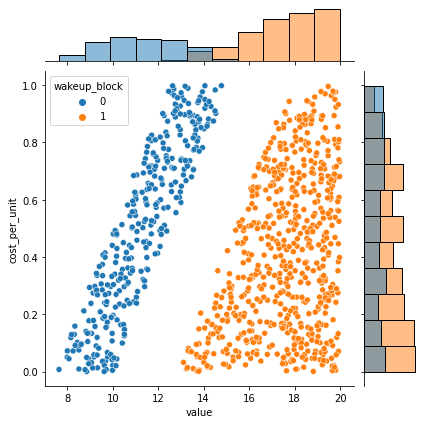

In [11]:
g = sns.JointGrid(data=user_txs_df[user_txs_df.block_height == 1], x="value", y="cost_per_unit", hue="wakeup_block")
g.plot(sns.scatterplot, sns.histplot)

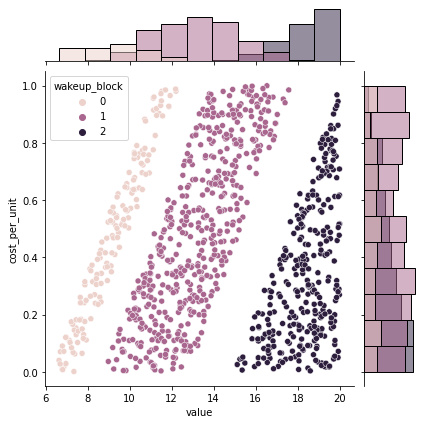

In [12]:
g = sns.JointGrid(data=user_txs_df[user_txs_df.block_height == 2], x="value", y="cost_per_unit", hue="wakeup_block")
g.plot(sns.scatterplot, sns.histplot)

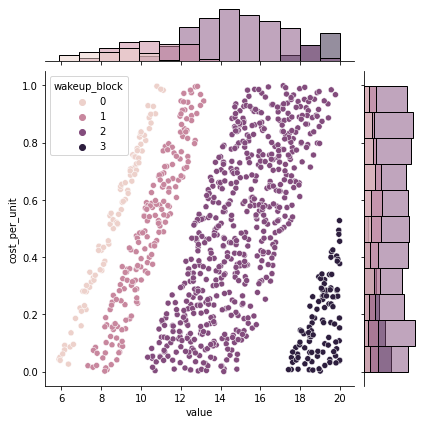

In [13]:
g = sns.JointGrid(data=user_txs_df[user_txs_df.block_height == 3], x="value", y="cost_per_unit", hue="wakeup_block")
g.plot(sns.scatterplot, sns.histplot)

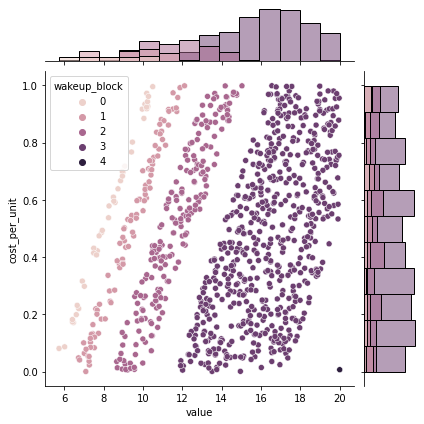

In [14]:
g = sns.JointGrid(data=user_txs_df[user_txs_df.block_height == 4], x="value", y="cost_per_unit", hue="wakeup_block")
g.plot(sns.scatterplot, sns.histplot)

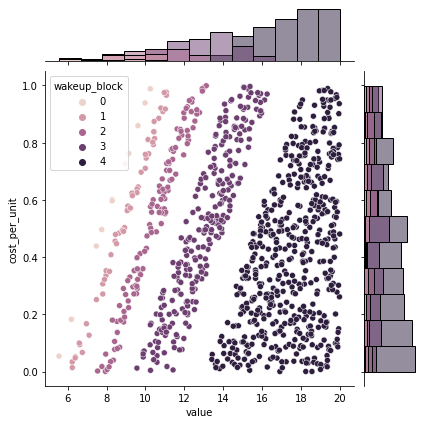

In [15]:
g = sns.JointGrid(data=user_txs_df[user_txs_df.block_height == 5], x="value", y="cost_per_unit", hue="wakeup_block")
g.plot(sns.scatterplot, sns.histplot)

Different rule: set slope to cost per unit and define max_block = first block after which payoff is negative.

In [4]:
class UserHurryEsc(UserFloatingEsc):
    
    def decide_parameters(self, params):
        basefee = params["basefee"]
        slope = self.cost_per_unit
        ramp_length = int(((self.value - basefee) / self.cost_per_unit - 1) / 2)
        max_fee = basefee + (ramp_length + 1) * self.cost_per_unit
        max_block = self.wakeup_block + ramp_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": basefee,
        }
        return tx_params

In [35]:
alice = UserHurryEsc(0)
alice.value = 10
alice.cost_per_unit = 0.8

bob = UserHurryEsc(0)
bob.value = 5
bob.cost_per_unit = 1.2

In [36]:
tx_params_alice = alice.decide_parameters({ "basefee": 1, "current_block": 0 })
tx_alice = TxFloatingEsc(
    sender = alice.pub_key,
    params = tx_params_alice
)
print(tx_alice)

Floating Escalator Transaction 462fb4f490f61544: start block 0, max block 5, start premium 0.8, max premium 4.800000000000001, max fee 5.800000000000001


In [37]:
tx_params_bob = bob.decide_parameters({ "basefee": 1, "current_block": 0 })
tx_bob = TxFloatingEsc(
    sender = bob.pub_key,
    params = tx_params_bob
)
print(tx_bob)

Floating Escalator Transaction c73a5694c26e492b: start block 0, max block 1, start premium 1.2, max premium 2.4, max fee 3.4


In [43]:
a = range(tx_params_alice["max_block"] + 1)
b = range(tx_params_bob["max_block"] + 1)

bfs = [i for i in a]
gps_a = [tx_alice.gas_price({ "basefee": bfs[i], "current_block": i }) for i in a]
gps_b = [tx_bob.gas_price({ "basefee": bfs[i], "current_block": i }) for i in b]
vft_a = [alice.value - i * alice.cost_per_unit for i in a]
vft_b = [bob.value - i * bob.cost_per_unit for i in b]

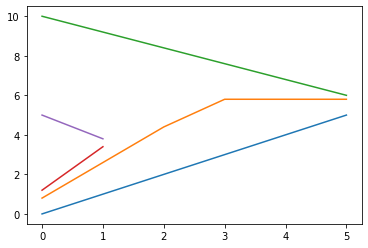

In [44]:
import matplotlib.pyplot as plt

plt.plot(a, bfs, a, gps_a, a, vft_a, b, gps_b, b, vft_b)